# Discretization of a convection-diffusion problem

The convection-diffusion equation on the domain $\Omega$ is given by

$$
    -\mu \Delta u + v \cdot \nabla u = f,
$$

where $v$ is the velocity and $\mu$ is the diffusivity. The problem is also confined by the Dirichlet condition 
$u = g$ on $\partial \Omega$.

In [1]:
%matplotlib inline
import dolfin as df
import sympy as sp
import numpy as np
import tabulate
import matplotlib.pyplot as plt

from utils import x, y, z
import utils

df.set_log_level(30)

Implementation of the convection-diffusion problem in one dimension using Dirichlet boundary conditions:

In [2]:
class ConvectionDiffusion:
    '''Convection-diffusion in 1D with Dirichlet boundary conditions.'''
    def __init__(self, mu, v, f, g):
        # convert constants to FEniCS friendly variables
        self.mu = utils.to_expression(mu) # diffusivity
        self.v = utils.to_expression(v)   # velocity
        self.f = utils.to_expression(f)   # source term
        self.g = utils.to_expression(g)   # Dirichlet boundary condition
        self.u = None
        
    def solve(self, N=32, order=1):
        mesh = df.UnitIntervalMesh(N)
        V = df.FunctionSpace(mesh, "CG", order)
        psi = df.TrialFunction(V)
        phi = df.TestFunction(V)
        self.u = df.Function(V)
        df.solve(self.a(psi, phi) == self.L(phi), self.u, self.bc(V))
        return self.u
    
    def a(self, psi, phi):
        '''Left hand side.'''
        a_diff = self.mu*psi.dx(0)*phi.dx(0)*df.dx
        a_conv = self.v*psi.dx(0)*phi*df.dx
        return a_diff + a_conv
    
    def L(self, phi):
        '''Right hand side.'''
        return self.f*phi*df.dx
    
    def bc(self, V):
        '''u(0) = 0 & u(1) = 1.'''
        return df.DirichletBC(V, self.g, utils.boundary)
    
    @property
    def mesh(self):
        return self.V.mesh()
    
    @property
    def V(self):
        return self.u.function_space()

Reproduce plots from lecture notes:

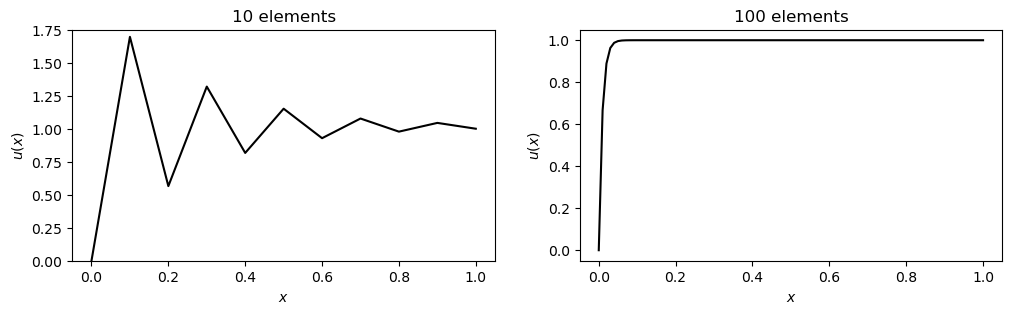

In [3]:
E0 = ConvectionDiffusion(mu=0.01, v=-1, f=0, g='x[0]')
plt.figure(figsize=(12, 3))
plt.subplot(121, title="10 elements", xlabel=r"$x$", ylabel=r"$u(x)$", ylim=(0, 1.75))
df.plot(E0.solve(N=10), color="black")
plt.subplot(122, title="100 elements", xlabel=r"$x$", ylabel=r"$u(x)$")
df.plot(E0.solve(N=100), color="black")
plt.show()

## Exercise 1

The central difference scheme defines the derivative as

$$
   [D_x u]_i = \frac{u_{i+1} - u_{i-1}}{2 h} .
$$

Transforming this into a matrix system $L u = u_x$, gives a matrix $L$ with non-zero elements in row $i$:

$$
     L_{i, i \pm 1} = \pm \frac{1}{2 h}. 
$$

Note that $L_{i \pm 1, i} = \mp \frac{1}{2 h}$, which means that $L$ is skew-symmetic, ($L_{i, j} = - L_{j, i}$).

The finite element method for describing $A u = u_x$ gives matrix elements

$$
    A_{i, j} = \int_\Omega \frac{\mathrm{d}\psi_i(x)}{\mathrm{d}x} \psi_j(x) \,\mathrm{d}x,
$$

where the trial functions $\psi_i$ and test functions $\psi_j$ are linear Lagrange polynomials. By defining the domain $x \in [x_s, x_f]$ and using integration by parts, we see that


$$
    A_{i, j} = 
    \left[\psi_i(x)\psi_j(x)\right]_{x_s}^{x_f} 
    - \int_{x_s}^{x_f}\frac{\mathrm{d}\psi_j(x)}{\mathrm{d}x} \psi_i(x)\,\mathrm{d}x 
    = \left[\psi_i(x)\psi_j(x)\right]_{x_s}^{x_f} - A_{j, i}.
$$

For the test and trial functions which are not on the boundary, we have that $\psi_i(x_s) = \psi_i(x_f) = 0$. This means that the non-boundary elements $A_{i, j}$ are skew-symmetric, as $A_{i, j} = - A_{j , i}$.

## Exercise 2

I assume example 3.1 is the standard Galerkin approximation.

This solves the diffusion-convection problem in one dimension on the unit interval. The equations are without a source term ($f(x) = 0)$, using negative velocity of $v(x) = -1$, and boundary conditions $u(0) = 0$ and $u(1) = 1$.

The exact solution in this case is

$$
    u_e = \frac{e^{-x/\mu} - 1}{e^{-1/\mu} - 1} .
$$

The corresponding FEniCS expression with a flexible value for $\mu$ is given below:

In [4]:
u_E2 = df.Expression('(exp(-x[0]/mu) - 1)/(exp(-1/mu) - 1)', degree=5, mu=0.01)

The Cea's constant is bounded by

$$
    C \geq \frac{||u_e - u_h||_{H_1}}{||u_e||_{k+1} h^{k}},
$$

where $u_e$ is the analytical solution and $u_h$ is its approximation on a mesh with element size $h$ and Lagrange elements of order $h$.

The corresponding implementation is given below:

In [9]:
class ConvectionDiffusion(ConvectionDiffusion):
    def Cea_constant(self, u_e, degree_rise=3):
        V = df.FunctionSpace(self.mesh, "CG", self.order + degree_rise)
        u = df.interpolate(u_e, V)
        H1 = self.Hk_norm(u - self.u, k=1)
        # H_{k+1}h^k
        k = self.order
        Hk = self.Hk_norm(u, k + 1)*self.h**k
        return H1/Hk
    
    def Hk_norm(self, f, k):
        I = f*f
        for _ in range(k):
            f = f.dx(0)
            I += f*f
        return df.sqrt(df.assemble(I*df.dx))
    
    @property
    def h(self):
        return self.mesh.hmin()
    
    @property
    def order(self):
        return self.V.ufl_element().degree()

Calculations of Cea's constant:

In [12]:
E2 = ConvectionDiffusion(mu=0.01, v=-1, f=0, g='x[0]')
for mu in [0.1, 0.01, 0.001]:
    u_E2.mu = mu
    E2.mu = df.Constant(mu)
    print(f"\nmu is {mu:g}.")
    table = []
    for N in [10, 100, 1_000, 10_000]:
        values = [f"{1/N:.1g}"]
        for p in range(3):
            E2.solve(N=N, order=p+1)
            values.append(E2.Cea_constant(u_E2))
        table.append(values)
    print(tabulate.tabulate(table, headers=['h', 'P1', 'P2', 'P3']))


mu is 0.1.
     h        P1         P2          P3
------  --------  ---------  ----------
0.1     0.279287  0.0352653  0.00295154
0.01    0.286918  0.0370609  0.00313192
0.001   0.287     0.0370805  0.00313318
0.0001  0.287001  0.0379234  0.273637

mu is 0.01.
     h        P1         P2          P3
------  --------  ---------  ----------
0.1     0.18971   0.01585    0.0010383
0.01    0.280827  0.0354378  0.00296614
0.001   0.288576  0.037246   0.00314754
0.0001  0.28866   0.0372657  0.00432681

mu is 0.001.
     h        P1         P2          P3
------  --------  ---------  ----------
0.1     0.968604  0.0495754  0.002617
0.01    0.187794  0.0158508  0.0010384
0.001   0.28084   0.0354395  0.00296628
0.0001  0.288591  0.0372478  0.00314769


I did think that Cea's constant should increase as $\mu$ decreases, but it does not seem to be the case?

## Exercise 3

The source term may be calculated for any exact solution $u_e$ with expressions for the velocity and the diffusivity.

Here is an implementation for manufactored solution for the convection-diffusion problem:

In [13]:
class ConvectionDiffusion(ConvectionDiffusion):
    @classmethod
    def MMS(cls, u_e, mu, v):
        u_x = sp.diff(u_e, x)
        u_xx = sp.diff(u_x, x)
        f = -mu*u_xx + v*u_x
        return cls(mu=mu, v=v, f=f, g=u_e)

Given $u_e = \sin(\pi x)$ with constant velocity $v = -1$ and arbitrary constant diffusivity we get: 

In [14]:
u_E3 = utils.to_expression(sp.sin(sp.pi*x))
    
for mu in [0.1, 0.01, 0.001]:
    E3 = ConvectionDiffusion.MMS(u_e=sp.sin(sp.pi*x), mu=mu, v=-1)
    print(f"\nmu is {mu:g}.")
    table = []
    for N in [10, 100, 1_000, 10_000]:
        values = [f"{1/N:.1g}"]
        for p in range(3):
            E3.solve(N=N, order=p+1)
            values.append(E3.Cea_constant(u_E3))
        table.append(values)
    print(tabulate.tabulate(table, headers=['h', 'P1', 'P2', 'P3']))


mu is 0.1.
     h        P1         P2          P3
------  --------  ---------  ----------
0.1     0.27405   0.0355679  0.00299298
0.01    0.273805  0.0353337  0.00298599
0.001   0.273803  0.0353313  0.00403193
0.0001  0.273803  0.0700703  0.226512

mu is 0.01.
     h        P1         P2          P3
------  --------  ---------  ----------
0.1     0.274464  0.0507292  0.00336434
0.01    0.273809  0.035623   0.00299635
0.001   0.273803  0.0353342  0.00352601
0.0001  0.273803  0.0361845  0.102481

mu is 0.001.
     h        P1         P2          P3
------  --------  ---------  ----------
0.1     0.27449   0.0822067  0.00358677
0.01    0.27381   0.0570779  0.00336215
0.001   0.273803  0.0356244  0.00323959
0.0001  0.273803  0.0359655  0.0243966


These values are very similar to E2, which I find a bit suspicious.

## Exercise 4

Using the *streamline diffusion Petrov-Galerkin* (SUPG), the test functions are given by

$$
    \phi_\text{P-V} = \phi + \beta h v \nabla\phi,
$$

where $\beta = 0.5$ is a new parameter, $h$ is element distance, and $\phi$ are the *common* Galerkin test functions.

This introduces strongly consistent diffusion. 

In [15]:
class SUPG(ConvectionDiffusion):
    def solve(self, beta=0.5, N=32, order=1):
        mesh = df.UnitIntervalMesh(N)
        h = mesh.hmin()
        V = df.FunctionSpace(mesh, "CG", order)
        psi = df.TrialFunction(V)
        phi = df.TestFunction(V)
        # Petrov-Galerkin:
        phi_PG = phi + beta*h*self.v*phi.dx(0)
        self.u = df.Function(V)
        df.solve(self.a(psi, phi_PG) == self.L(phi_PG), self.u, self.bc(V))
        return self.u

Comparing solutions using coarse grid ($h = 0.1$):

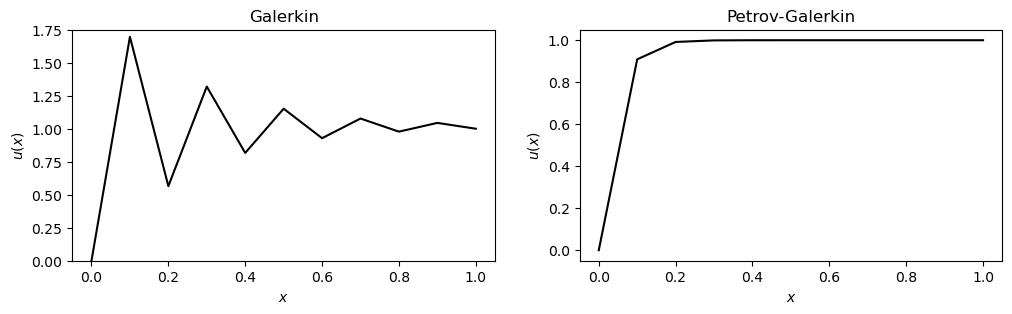

In [16]:
E4 = SUPG(mu=0.01, v=-1, f=0, g='x[0]')
plt.figure(figsize=(12, 3))
plt.subplot(121, title="Galerkin", xlabel=r"$x$", ylabel=r"$u(x)$", ylim=(0, 1.75))
df.plot(E0.solve(N=10), color="black")
plt.subplot(122, title="Petrov-Galerkin", xlabel=r"$x$", ylabel=r"$u(x)$")
df.plot(E4.solve(N=10), color="black")
plt.show()

Cea's constant using the old definition gives:

In [17]:
for mu in [0.1, 0.01, 0.001]:
    E4 = SUPG.MMS(u_e=sp.sin(sp.pi*x), mu=mu, v=-1)
    print(f"\nmu is {mu:g}.")
    table = []
    for N in [10, 100, 1_000, 10_000]:
        values = [f"{1/N:.1g}"]
        for p in range(3):
            E4.solve(N=N, order=p+1)
            values.append(E4.Cea_constant(u_E3))
        table.append(values)
    print(tabulate.tabulate(table, headers=['h', 'P1', 'P2', 'P3']))


mu is 0.1.
     h        P1                P2                P3
------  --------  ----------------  ----------------
0.1     0.285801      12.2452          137.214
0.01    0.296327    1611.92         204897
0.001   0.297621  165847                 2.2621e+08
0.0001  0.297753       1.66506e+07       1.15685e+08

mu is 0.01.
     h        P1                P2                P3
------  --------  ----------------  ----------------
0.1     0.273566       2.76812          10.6492
0.01    0.274099    1124.15         122879
0.001   0.274215  158757                 2.16031e+08
0.0001  0.274228       1.65763e+07       1.15166e+08

mu is 0.001.
     h        P1                P2               P3
------  --------  ----------------  ---------------
0.1     0.274166       0.324407         0.995906
0.01    0.273801     277.392        10587.7
0.001   0.273806  111068                1.29733e+08
0.0001  0.273807       1.58658e+07      1.09963e+08


This behaves quite well for $P1$ elements, but not for higher degrees.

Using Petrov-Galerkin, Cea's constant is bounded by

$$
    C \geq \frac{||u_e - u_h||_{sd}}{||u_e||_{k+1} h^{k + 0.5}},
$$

where the SUPG norm is given by

$$
    ||u||_{sd} = \left(h||v\cdot \nabla u||^2_{H^1} + \mu |\nabla u|^2_{H^1} \right)^{1/2} .
$$

In [24]:
class SUPG(ConvectionDiffusion):
    def Cea_constant(self, u_e, degree_rise=4):
        V = df.FunctionSpace(self.V.mesh(), "CG", self.order + degree_rise)
        u = df.interpolate(u_e, V)
        # ||u - uh||_sd
        e_x = u.dx(0) - self.u.dx(0)
        H1 = self.Hk_norm(self.v*e_x, k=1)
        H1_ = utils.H1_seminorm(e_x)
        SUPG = df.sqrt(self.h*H1**2 + self.mu*H1_**2)
        # H_{k+1}h^k
        Hk = self.norm(u, self.order + 1)*self.h**(self.order + 1/2)
        return SUPG/Hk

Constant values:

In [25]:
for mu in [0.1, 0.01, 0.001]:
    E4 = SUPG.MMS(u_e=sp.sin(sp.pi*x), mu=mu, v=-1)
    print(f"\nmu is {mu:g}.")
    table = []
    for N in [10, 100, 1_000, 10_000]:
        values = [f"{1/N:.1g}"]
        for p in range(3):
            E4.solve(N=N, order=p+1)
            values.append(E4.Cea_constant(u_E3))
        table.append(values)
    print(tabulate.tabulate(table, headers=['h', 'P1', 'P2', 'P3']))


mu is 0.1.
     h           P1           P2          P3
------  -----------  -----------  ----------
0.1         13.4163      3.87072     0.54791
0.01       314.575      90.7678     12.8361
0.001     9532.11     2750.39      364.929
0.0001  300086       86357.1      1407.61

mu is 0.01.
     h           P1           P2          P3
------  -----------  -----------  ----------
0.1         9.95153      3.13585    0.432603
0.01      134.136       38.7669     5.48636
0.001    3145.75       907.69     120.706
0.0001  95321.1      27431        449.509

mu is 0.001.
     h           P1         P2          P3
------  -----------  ---------  ----------
0.1         9.53606     3.7159    0.422244
0.01       99.4778     32.986     4.32841
0.001    1341.35      387.678    52.1773
0.0001  31457.5      9052.83    153.773


These results seem to be incorrect. The constant stabilizes a lot if the formula is changed to

$$
    C \geq \frac{||u_e - u_h||_{sd}}{||u_e||_{k+1} h^{k - 0.5}}.
$$

In [28]:
class SUPG(ConvectionDiffusion):
    def Cea_constant_new(self, u_e, degree_rise=4):
        V = df.FunctionSpace(self.V.mesh(), "CG", self.order + degree_rise)
        u = df.interpolate(u_e, V)
        # ||u - uh||_sd
        e_x = u.dx(0) - self.u.dx(0)
        H1 = self.Hk_norm(self.v*e_x, k=1)
        H1_ = utils.H1_seminorm(e_x)
        SUPG = df.sqrt(self.h*H1**2 + self.mu*H1_**2)
        # H_{k+1}h^k
        Hk = self.norm(u, self.order + 1)*self.h**(self.order - 1/2)
        return SUPG/Hk

As you can see:

In [29]:
for mu in [0.1, 0.01, 0.001]:
    E4 = SUPG.MMS(u_e=sp.sin(sp.pi*x), mu=mu, v=-1)
    print(f"\nmu is {mu:g}.")
    table = []
    for N in [10, 100, 1_000, 10_000]:
        values = [f"{1/N:.1g}"]
        for p in range(3):
            E4.solve(N=N, order=p+1)
            values.append(E4.Cea_constant_new(u_E3))
        table.append(values)
    print(tabulate.tabulate(table, headers=['h', 'P1', 'P2', 'P3']))


mu is 0.1.
     h        P1        P2        P3
------  --------  --------  --------
0.1      1.34163  0.387072  0.054791
0.01     3.14575  0.907678  0.128361
0.001    9.53211  2.75039   0.364929
0.0001  30.0086   8.63571   0.140761

mu is 0.01.
     h        P1        P2         P3
------  --------  --------  ---------
0.1     0.995153  0.313585  0.0432603
0.01    1.34136   0.387669  0.0548636
0.001   3.14575   0.90769   0.120706
0.0001  9.53211   2.7431    0.0449509

mu is 0.001.
     h        P1        P2         P3
------  --------  --------  ---------
0.1     0.953606  0.37159   0.0422244
0.01    0.994778  0.32986   0.0432841
0.001   1.34135   0.387678  0.0521773
0.0001  3.14575   0.905283  0.0153773


There is probably either something wrong in the implementation or in the definition of the constant.

## Exercise 5

Coersivity condition:

$$
    a(u, u) \geq \alpha ||u||^2_V \quad\forall u \in V, 
$$

where $V$ is a Hilbert space and $a(\cdot, \cdot)$ is a bilinear form.

We assume homogeneous Neumann condition on the outflow and that $v \cdot n > 0$.

First, we see that the bilinear form is divided into two terms:

$$
    a(u, u) = b_\mu(u, u) + c_v(u, u). 
$$

Starting by looking at the first term:

$$
     b_\mu(u, u) = \mu \int_\Omega (\nabla u)^2 \,\mathrm{d}x  = \mu |u|_{H^1}^2
$$

Although we have not shown this yet, we will assume that Poincaré inequality 
($||u||_{L^P} \leq C_\Omega ||\nabla u||_{L^P}$)
holds for the homogenious Neumann conditions too. A quick rewrite to $H$-norms gives

$$
    ||u||_{H^1}^2 \leq (C^2 + 1)|u|_{H^1}^2 = \frac{C^2 + 1}{\mu} b_\mu(u, u),
$$

which holds as long as $\mu$ is positive.

It then remains to look at $c_v(u, u)$. When in doubt, do integration by parts:

$$
    c_v(u, u) = \int_\Omega (v \cdot \nabla u) u  \,\mathrm{d}x 
    = - \int_\Omega (v \cdot \nabla u) u  \,\mathrm{d}x 
    - \int_\Omega (\nabla \cdot v) u^2  \,\mathrm{d}x 
    + \int_{\partial\Omega} u^2 (v \cdot n)  \,\mathrm{d}s .
$$

From which we obtain: 

$$
    2 c_v(u, u) = 
     - \int_\Omega (\nabla \cdot v) u^2  \,\mathrm{d}x 
    + \int_{\partial\Omega} u^2 (v \cdot n)  \,\mathrm{d}s .
$$

The second integral is clearly positive since $u^2 \geq 0$ and $v \cdot n > 0$. The question then only lies on the first integral.

In the case of an incompressible flow ($\nabla \cdot v = 0$) then $c_v(u, u)$ must be positive. We then have that

$$
    a(u, u) \geq b(u, u) \geq \frac{\mu}{C^2 + 1}||u||_{H^1}^2.
$$



In the case of compressible flow ($\nabla \cdot v \neq 0$), then the positivity constraint is only valid if 

## Exercise 6

## Exercise 7

## Exercise 8